# Sentiment analysis for Twitter Text
- Primary step of the Morality based sentimental analysis. Text is tockenized using TF-IDF vectorization and BERT

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,BertPreTrainedModel, BertConfig,BertModel, AutoTokenizer,get_scheduler,AdamW
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import requests
import os
import zipfile

c:\Users\anura\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset from CSV file
file_path = r"C:\Users\anura\OneDrive\Desktop\proj\moralFoundations\updated_data.csv"  # Replace with the actual file path
df = pd.read_csv(file_path, encoding = "ISO-8859-1")

# Display the first few rows of the dataset
print(df.head())

  Corpus                                         Tweet Text  Stance  \
0    EVM  #EVMs are easy to manipulate . This was demons...       1   
1    CAA             Congratulations\nCAA  is arrived  #CAA       1   
2    CAA  My dear Indian muslims we are 35 crores of pop...      -1   
3    CAA  This guy was part of anti Hindu protests in th...       1   
4    CAA  Woman protester breaks down while speaking to ...       0   

  Foundation  cleaned_tweet  
0   fairness            NaN  
1    loyalty            NaN  
2    loyalty            NaN  
3  authority            NaN  
4       care            NaN  


In [4]:
# Find the number of rows for each unique value in the first column
class_counts = df.iloc[:, 0].value_counts()

# Print the counts for each class
print("Number of rows for each class:")
print(class_counts)

# Print the total number of rows
total_rows = df.shape[0]
print("\nTotal number of rows:", total_rows)

Number of rows for each class:
Corpus
CAA                     207
UCC                     190
EVM                     180
Animal Sacrifices       166
Anti Conversion Laws    162
LGBTQ                   160
Brain Drain             148
Name: count, dtype: int64

Total number of rows: 1213


In [5]:
df = df[df["Foundation"].notna()]

In [6]:
# Preprocess the data
X = df['Tweet Text']
y = df['Foundation']

In [7]:
print(y)

0        fairness
1         loyalty
2         loyalty
3       authority
4            care
          ...    
1208     fairness
1209       purity
1210      loyalty
1211      loyalty
1212         care
Name: Foundation, Length: 1099, dtype: object


# Bert Model
- The data set is limited(1213 Tweets).
- Model is designed with bert as encoder and fully connected layers as classifier
- Performing K(5 here) fold cross validation for analyzing the performance of the model on the dataset.

In [35]:
# Model Setup
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [36]:
class BertForSentimentAnalysis(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.3)  # Reduce dropout

        # self.fc1 = nn.Linear(config.hidden_size, 512)  # One small FC layer
        # self.relu = nn.ReLU()
        self.classifier = nn.Linear(config.hidden_size, 5)  # Output layer

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output  # [CLS] token representation

        x = self.dropout(pooled_output)
        # x = self.fc1(x)
        # x = self.relu(x)

        logits = self.classifier(x)  # Final predictions

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}


In [11]:
def k_fold_cross_validation(model, dataset, texts, label_encoder, k=5, batch_size=8, epochs=3, lr=2e-5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    losses, accuracies, precisions, recalls, f1_scores = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\nFold {fold+1}/{k}")

        # Create dataset subsets instead of samplers
        train_dataset = Subset(dataset, train_idx)
        val_dataset = Subset(dataset, val_idx)

        # Define training arguments
        training_args = TrainingArguments(
            output_dir=f"./results/fold{fold}",
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            evaluation_strategy="epoch",
            save_strategy="no",
            learning_rate=lr,
            weight_decay=0.1,
            logging_dir="./logs",
            logging_steps=10
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        # Train & Evaluate
        trainer.train()
        eval_result = trainer.evaluate()
        losses.append(eval_result["eval_loss"])

        # Predictions & Labels
        all_preds, all_labels, misclassified_samples = [], [], []

        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs["logits"]  # BERT outputs logits
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Store misclassified samples
                for i, (pred, true) in enumerate(zip(preds, labels)):
                    if pred != true:
                        misclassified_samples.append((texts[val_idx[batch_idx * batch_size + i]], true.item(), pred.item()))

        # Compute Metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"Misclassifications per Class (Actual → Predicted):\n{cm - np.diag(np.diag(cm))}")

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_encoder.classes_), yticklabels=list(label_encoder.classes_))
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - Fold {fold+1}")
        plt.show()

        # Print some misclassified tweets
        print("\nMisclassified Tweets:")
        for text, true, pred in misclassified_samples[:5]:  # Show first 5 misclassified examples
            print(f" Tweet: \"{text}\" | True: {true} | Predicted: {pred}")

    # Print Final Averages
    print(f"\nFinal Results Across {k} Folds:")
    print(f"Avg Loss: {np.mean(losses):.4f}")
    print(f"Avg Accuracy: {np.mean(accuracies):.4f}")
    print(f"Avg Precision: {np.mean(precisions):.4f}")
    print(f"Avg Recall: {np.mean(recalls):.4f}")
    print(f"Avg F1-Score: {np.mean(f1_scores):.4f}")

In [12]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [13]:
#label encodings for moral foundations
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [14]:
MAX_LEN = 128
bert_train_dataset = CustomDataset(X.tolist(), y.tolist(), bert_tokenizer, MAX_LEN)
# bert_test_dataset = CustomDataset(X_test.tolist(), y_test.tolist(), bert_tokenizer, MAX_LEN)

In [15]:
bert_labels, bert_preds = [],[]
def evaluate_on_test(model, test_dataset, batch_size=8):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Store predictions & true labels

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            preds = torch.argmax(logits, dim=1)

            bert_preds.extend(preds.cpu().numpy())
            bert_labels.extend(labels.cpu().numpy())



In [16]:
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=5)
model = BertForSentimentAnalysis.from_pretrained("bert-base-uncased", config=config)

Some weights of BertForSentimentAnalysis were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSentimentAnalysis(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [18]:
text = df["Tweet Text"].tolist()

In [19]:
print(label_encoder.classes_)

['authority' 'care' 'fairness' 'loyalty' 'purity']


In [33]:
torch.cuda.empty_cache()

In [34]:
# Perform K-Fold Cross-Validation on training data
k_fold_cross_validation(model, bert_train_dataset, k=5, batch_size=8, epochs=3, lr=2e-5, texts = text,label_encoder=  label_encoder)

TypeError: k_fold_cross_validation() got an unexpected keyword argument 'label_encoder'

# Tfidf with lstm
- The data set is limited(1207 Tweets).
- Data encoded using TF-IDF vectorizer and fed to lstm for classification
- Performing K(5 here) fold cross validation for analyzing the model

In [22]:
class SentimentDataset(Dataset):
    def __init__(self, sequences, labels, vectorizer):
        self.sequences = vectorizer.transform(sequences).toarray()  # Transform text to numerical features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.sequences[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [23]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, batch_first=True,bidirectional = True)

        self.hidden1 = nn.Linear(hidden_dim*2, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.hidden3 = nn.Linear(64, 32)
        self.classifier = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
      # Reshape input to (batch_size, sequence_length=1, input_size)
      x = x.unsqueeze(1)
      _, (hidden, _) = self.bilstm(x)
      hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Concatenate the last two hidden states
      #output = self.dropout(hidden[-1])
      output = self.hidden1(hidden)
      output = self.dropout(output)
      output = self.hidden2(output)
      output = self.dropout(output)
      output = self.hidden3(output)
      output = self.dropout(output)
      return self.classifier(output)

In [24]:
def k_fold_cross_validation(model, dataset, texts, labels, k=5, batch_size=8, epochs=5, lr=1e-3):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    accuracies, precisions, recalls, f1_scores = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n🔹 Fold {fold+1}/{k}")

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        for epoch in range(epochs):
            model.train()
            for batch in train_loader:
                optimizer.zero_grad()

                features = batch['features'].to(device)
                labels = batch['label'].to(device)

                outputs = model(features)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            scheduler.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                outputs = model(features)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['label'].cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"✅ Fold {fold+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for Fold {fold+1}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    print(f"\n🎯 Final Results Across {k} Folds:")
    print(f"Avg Accuracy: {np.mean(accuracies):.4f}")
    print(f"Avg Precision: {np.mean(precisions):.4f}")
    print(f"Avg Recall: {np.mean(recalls):.4f}")
    print(f"Avg F1-Score: {np.mean(f1_scores):.4f}")


In [25]:
vectorizer = TfidfVectorizer(max_features=512)
features = vectorizer.fit_transform(X).toarray()
vocab = vectorizer.get_feature_names_out()

In [26]:
input_dim = features.shape[1]
hidden_dim = 256
output_dim = 5

In [27]:
print(input_dim)

512


In [28]:
dataset = SentimentDataset(X, y, vectorizer)

In [29]:
model = LSTMClassifier(input_dim, hidden_dim, output_dim)


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMClassifier(
  (bilstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  (hidden1): Linear(in_features=512, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (hidden3): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


🔹 Fold 1/5
✅ Fold 1 - Accuracy: 0.4045, Precision: 0.4078, Recall: 0.4045, F1-score: 0.4054


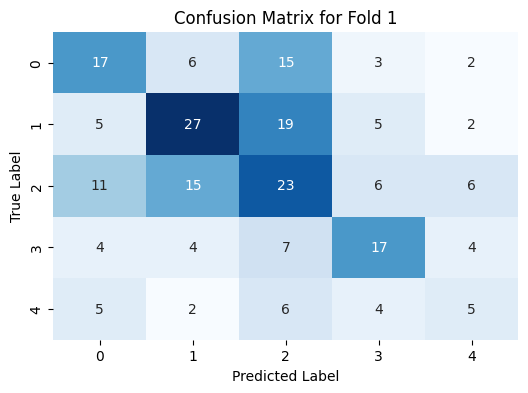


🔹 Fold 2/5
✅ Fold 2 - Accuracy: 0.7455, Precision: 0.7476, Recall: 0.7455, F1-score: 0.7437


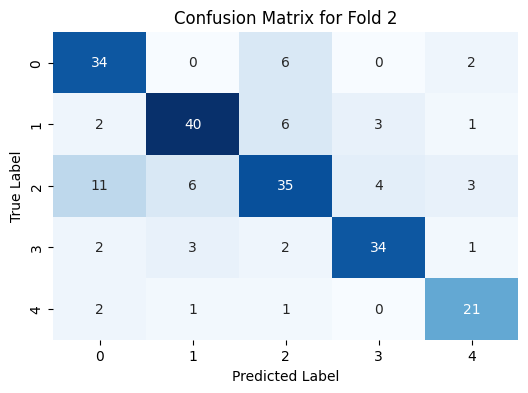


🔹 Fold 3/5
✅ Fold 3 - Accuracy: 0.8182, Precision: 0.8435, Recall: 0.8182, F1-score: 0.8181


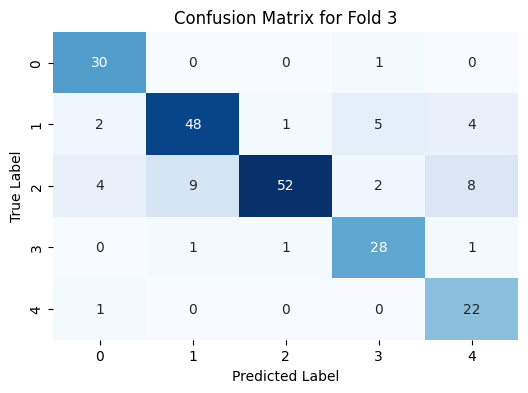


🔹 Fold 4/5
✅ Fold 4 - Accuracy: 0.8545, Precision: 0.8604, Recall: 0.8545, F1-score: 0.8537


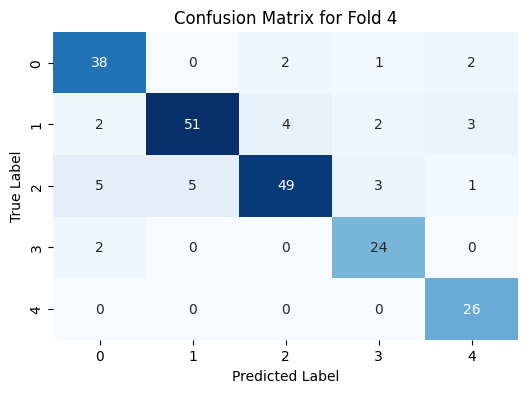


🔹 Fold 5/5
✅ Fold 5 - Accuracy: 0.8813, Precision: 0.8877, Recall: 0.8813, F1-score: 0.8785


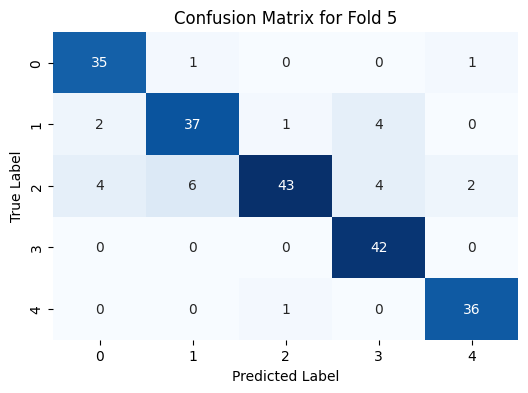


🎯 Final Results Across 5 Folds:
Avg Accuracy: 0.7408
Avg Precision: 0.7494
Avg Recall: 0.7408
Avg F1-Score: 0.7399


In [31]:
k_fold_cross_validation(model, dataset, X, y)